Dit is de EDA voor BE.... bestanden, be52.. bestanden. Dit bevat verschillende instel waardes voor de linac bij een bepaalde energie. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_db = pd.read_csv("data/cal_changed.csv", header = None, names=["date", "linac", "file_name", "item", 'part', "value"], )
names_files = list(set(df_db["file_name"]))
df_db

,date,linac,file_name,item,part,value
0,2023-09-13,2325,Be5201,1,4,5201
1,2023-10-04,2325,Be5201,1,4,5201
2,2023-10-11,2325,Be5201,1,4,5201
3,2023-10-18,2325,Be5201,1,4,5201
4,2023-10-25,2325,Be5201,1,4,5201
...,...,...,...,...,...,...
205741,2023-12-20,2325,Optics_LP_Y_61_To_80,2379,299,5385
205742,2024-01-31,2325,Optics_LP_Y_61_To_80,2379,299,5384
205743,2024-03-20,2325,Optics_LP_Y_61_To_80,2379,299,5384
205744,2024-04-24,2325,Optics_LP_Y_61_To_80,2379,299,5383


Deze set bevat een aantal bestanden

{'Be52', 'Be55', 'Be63'}

{'Mlc_Iso_Centre',
 'Mlc_Leaf_Sensor_Dir',
 'Mlc_Leaf_Sensor_Gain',
 'Mlc_Leaf_Sensor_Off',
 'Mlc_Leaf_Sensor_Orig',
 'Mlc_Minr_Off',
 'Mlc_Sensor_Gains',
 'Mlc_cal_data',
 'Mlc_gain_adj',
 'Mlc_leaf_travel',
 'Mlc_refl_width'}

 {'Optics_Dist_Y1_01_To_40',
 'Optics_Dist_Y1_41_To_80',
 'Optics_Dist_Y2_01_To_40',
 'Optics_Dist_Y2_41_To_80',
 'Optics_Gen_Cal_Data',
 'Optics_LP_X_01_To_20',
 'Optics_LP_X_21_To_40',
 'Optics_LP_X_41_To_60',
 'Optics_LP_X_61_To_80',
 'Optics_LP_Y_01_To_20',
 'Optics_LP_Y_21_To_40',
 'Optics_LP_Y_41_To_60',
 'Optics_LP_Y_61_To_80'}


Er gaat een focus naar de Be.... bestanden


In [4]:
be52 = [name for name in names_files if "Be52" in name]
be52

['Be5214',
 'Be5212',
 'Be5215',
 'Be5217',
 'Be5213',
 'Be5216',
 'Be5206',
 'Be5202',
 'Be5201',
 'Be5219',
 'Be5207',
 'Be5211',
 'Be5205',
 'Be5218',
 'Be5209',
 'Be5204',
 'Be5208']

In [5]:
be5201 = [row for row in df_db.itertuples() if row.file_name == "Be5201"]
be5201 = pd.DataFrame(be5201)
be5201

,Index,date,linac,file_name,item,part,value
0,0,2023-09-13,2325,Be5201,1,4,5201
1,1,2023-10-04,2325,Be5201,1,4,5201
2,2,2023-10-11,2325,Be5201,1,4,5201
3,3,2023-10-18,2325,Be5201,1,4,5201
4,4,2023-10-25,2325,Be5201,1,4,5201
...,...,...,...,...,...,...,...
5350,5350,2024-02-07,2325,Be5201,1194,128,0
5351,5351,2024-02-14,2325,Be5201,1194,128,0
5352,5352,2024-02-28,2325,Be5201,1194,128,0
5353,5353,2024-04-24,2325,Be5201,1194,128,0


1 bestand bestaat uit: item, part en value waardes. Deze zijn meerendeels vertaald naar woorden. 

linac_items, linac_parts en itemValue_df zijn verbonden met de BE.... bestand3en.

agility_parts en mlc_parts zijn verbonden met de andere bestanden.

In [6]:
# loading of the translate tables
linac_items = pd.read_csv("../translate_tbl.csv")
linac_items["Item name"] =  linac_items["Item name"].str.extract(r'i(\d+)').astype("float")
itemValue_df = pd.read_csv("../translate_tbl_item.csv", header = None)
linac_parts = pd.read_csv("../Itemparts.csv")
agility_parts = pd.read_csv("../agility_parts.csv")
mlc_parts = pd.read_csv("../MLC.csv")

# editing the loaded table because it contains 28 smaller tables
table_indices = itemValue_df[itemValue_df[1].str.contains('Table', na=False)].index.tolist()
table_indices.append(len(itemValue_df))
itemValue_dfs = [
    itemValue_df.iloc[table_indices[i] + 1:table_indices[i + 1]]
    for i in range(len(table_indices) - 1)
]

for index in range(len(itemValue_dfs)):
    df = itemValue_dfs[index].dropna(subset=[0])
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    itemValue_dfs[index] = df


# filling in the gaps in the agility_parts and mlc_parts
def fillinthestrips(df):
    new_rows = []

    for _, row in df.iterrows():
        if "See Item" in str(row['Description']):
            # Extract the referenced item number
            ref_item = int(row['Description'].split("Item ")[1].split(" ")[0])
            # Get all parts of the referenced item
            ref_parts = df[df['Item'] == ref_item].copy()
            # Update item number and collect rows
            ref_parts['Item'] = row['Item']
            new_rows.extend(ref_parts.to_dict('records'))
        else:
            new_rows.append(row.to_dict())

    # Create the new DataFrame
    return pd.DataFrame(new_rows).reset_index(drop=True)
    
mlc_parts = fillinthestrips(mlc_parts)
agility_parts = fillinthestrips(agility_parts)

# combining the 2 tables
unique_df = pd.concat([mlc_parts, agility_parts]).drop_duplicates(
    subset=['Item', 'Part'], 
    keep='first'
).reset_index(drop=True)

unique_df["Part"] = unique_df["Part"].astype(int)

De vertaal tabbelen zijn nu compleet en kunnen worden gebruikt.

itemValues_dfs indexen:)
1 = i2
2 = i7
3 = i8
4 = i9
5 = i32
6 = i39
7 = i40
8 = i41
9 = i42
10 = i182
11 = i199
12 = i200
13 = i201
14 = i202
15 = i203
16 = i245
17 = i268
18 = i318
19 = i319
20 = i382
21 = i383
22 = i408
23 = i409
24 = i410
25 = i416
26 = i418
27 = i433
28 = i494
29 = i553
30 = i685
31 = i686
32 = i650


In [7]:
description = {}

for row in be5201.itertuples():
    item = linac_items[linac_items["Item name"] == row.item]
    part = linac_parts[linac_parts["Part No."] == row.part]
    if not item.empty and not part.empty:
        description[str(item.iloc[0,2])] = str(part.iloc[0,2])

{'This item identifies the energy calibration block that is currently set on the linear accelerator. The last two digits of the item value correspond to the energy code. If a wedge is prescribed, an offset value of 20 is applied to the identities of X-ray calibration blocks.': 'Actual value',
 'This item selects the radiation type to be delivered by the linear accelerator.': 'Actual value',
 'This item selects the required energy.': 'Actual value',
 'This item specifies the default nominal dose rate to be applied if a zero or invalid entry is made for the prescribed nominal dose rate. Part 1 of this item sets the value. It can be set for each energy.': 'Setting value',
 'This item specifies the nominal dose rate to be used for the current segment by dose channel 1. It is exactly equivalent to writing to the nominal dose rate. The displayed value shows the actual dose rate being produced by the linear accelerator.': 'Process_Param_14_Part ',
 'The displayed value of this item shows the actual dose rate being produced by the linear accelerator for dose channel 2.': 'Gain 1',
 'The prescribed or keyboard-entered value of this item may be applied using ASU to cause assisted setup of the gantry.': 'Confirmed value',
 'The prescribed or keyboard-entered value of this item may be applied using ASU to cause assisted setup of the beam limited device angle.  The displayed Actual value shows the actual head angle.': 'Confirmed value',
 'The prescribed or keyboard-entered value of this item can be applied by using ASU to cause assisted setup of the X1 diaphragm.': 'Confirmed value',
 'The prescribed or keyboard-entered value of this item is used during a movement segment to determine the required START position of the X2 diaphragm.': 'Confirmed value',
 'The prescribed or keyboard-entered value of this item can be applied using ASU to cause assisted setup of the Y1 diaphragm.': 'Confirmed value',
 'The prescribed or keyboard-entered value of this item can be applied using ASU to cause assisted setup of the Y2 diaphragm.': 'Confirmed value',
 'This item allows the magnetron tuner rest position to be set for each energy and stored in the calibration block.': 'Setting value',
 'This item shows the servo error from the slits gun control system. The item is not used in digital accelerators fitted with a slitless flight tube and hardware gun servo.': 'Parameter 3 function',
 'This item maintains the sum of the two 2R plates.': 'Gain 2',
 'This item shows the servo error from the 2R plates centring system.': 'Process_Param_19_Part ',
 'This item shows the servo error from the 2T plates centring system.': 'Process_Param_19_Part ',
 'This item shows the servo error from the RF phase error detector.': 'Confirmed value',
 'The monitor item of the gantry movement check potentiometer, calibrated directly in volts.': 'Confirmed value',
 'This item monitors the relative readings of a number of signals from the ion chamber plates. During the set up procedure, each reading is normalized against the first channel.': 'Gain 1',
 'The magnetron tuner servo control item.': 'Process_Param_19_Part ',
 'The high power phase shifter servo control item.': 'Confirmed value',
 'The low power phase shifter servo control item.': 'Confirmed value',
 'The 2R servo control item controls the current required to make the beam symmetrical.': 'Process_Param_19_Part ',
 'The 2T servo control item controls the current required to make the beam symmetrical.': 'Process_Param_19_Part ',
 'The value of this item is the hump error.': 'Process_Param_19_Part ',
 'This item controls the loop gain of the hardware system. It is configured for the hardware gun servo option only.': 'Setting value',
 'This item controls an analog reference voltage used by the hardware gun servo option.': 'Setting value',
 'The monitor item of the inner plate of the ion chamber.': 'Confirmed value',
 'The monitor item of the outer plate of the ion chamber.': 'Confirmed value',
 'The monitor item of the 2TB plate.': 'Confirmed value',
 'The monitor item of the 2TA plate.': 'Confirmed value',
 'The monitor item of the 2RG plate.': 'Confirmed value',
 'The monitor item of the 2RT plate.': 'Confirmed value',
 'This item monitors the position of the wedge.': 'Setting value',
 'This partial digital word indicates the selected target type.': 'Setting value',
 'Indicates whether high energy X-rays have been selected as the energy type.': 'Setting value',
 'This item monitors the position of the secondary collimator.': 'Setting value',
 'This item indicates whether an applicator is present at the beam limiting device.': 'Setting value',
 'The value of this item is the monitored voltage across the magnetron filament.': 'Confirmed value',
 'This item monitors the magnetron magnet voltage. It is obtained from the rectifier and smoothing circuit in the LV PSU via LV PSU control PCB 13D and the SCC-RHB and AI12-RHB PCBs in the RHCA.': 'Setting value',
 'The value of this item is the monitored voltage of the electron gun.': 'Confirmed value',
 'Not available.': 'Setting value',
 'This item monitors ion chamber temperature probe 1, if fitted as part of the dose compensation option.': 'Confirmed value',
 'This item monitors ion chamber temperature probe 2, if fitted as part of the dose compensation option. The item is part of the dual temperature monitoring system.': 'Confirmed value',
 'This item shows the monitored position of the high power phase shifter.': 'Setting value',
 'This item sets the position of the low power phase shifter of the AFC system.': 'Setting value',
 'This item is the signal from phase leg 1 of the AFC system.': 'Confirmed value',
 'This item is the signal from phase leg 2 of the AFC system.': 'Confirmed value',
 'This item is not used when the digital accelerator is fitted with a slitless flight tube and hardware gun servo.': 'Confirmed value',
 'The value of this item is the HT current used by the magnetron filament rundown.': 'Confirmed value',
 'This item monitors the target check position potentiometer, which is used to interlock the target position': 'Setting value',
 'This is the servo control item for the coarse (main) bending magnet current. It shows the readback value from LV PSU control PCB 13C in the low voltage PSU assembly (Area 13).': 'Setting value',
 'This is the servo control item for the fine (top-up) bending magnet current. It shows the readback value from LV PSU control PCB 13G in the low voltage PSU assembly (Area 13).': 'Setting value',
 'This is the servo control item for the focus 1 current. It shows the readback value from LV PSU control PCB 13F in the low voltage PSU assembly (Area 13).': 'Setting value',
 'This is the servo control item for the focus 1 current. It shows the readback value from LV PSU control PCB 13E in the low voltage PSU assembly (Area 13).': 'Setting value',
 'Sets the balance gain for the 2R coil.': 'Setting value',
 'Sets the loop gain for the 2R coil.': 'Setting value',
 'Sets the balance gain for the 2T coil.': 'Setting value',
 'Sets the loop gain for the 2T coil.': 'Setting value',
 'Sets the balance gain for the slitted flight tube.': 'Setting value',
 'Sets the loop gain for the slitted flight tube.': 'Setting value',
 'nan': 'Confirmed value',
 'This item sets the calibration of dosimetry channel 2. Increase the value of this item to increase the dose rate reading. (See i314 for more details.)': 'Confirmed value',
 'The control item for the target.': 'Setting value',
 'The control item for the primary collimator.': 'Setting value',
 'This item sets the position of the primary (scatter) filter.': 'Setting value',
 'This item sets the position of the scatter filter.': 'Setting value',
 'This item sets the magnetron filament voltage. The magnetron filament voltage is controlled by a circuit that monitors the HT current and hence the magnetron power. The control circuit then adjusts the required voltage accordingly.': 'Parameter 5 function',
 'The servo control item for the electron gun filament current.': 'Process_Param_24_Part ',
 'The servo control item for the magnetron magnet power supply. It sends a current setting value to i539.': 'Setting value',
 'This item sets the charge rate value in the HT PSU.': 'Setting value',
 'The control item for the 1T centring coil.': 'Setting value',
 'The control item for the 1R centring coil.': 'Setting value',
 'This item indicates the expected time for each steps and adds 20% and increments the total set accordingly.': 'Parameter 1 function',
 'This item controls the gun aim level for servo operation. The item is not used when the digital accelerator is fitted with a slitless flight tube and a hardware gun servo.': 'Setting value',
 'This item shows whether the HIGH/LOW power selection contactors have correctly selected HIGH power.': 'Setting value',
 'This item shows whether the HIGH/LOW power selection contactors have correctly selected LOW power.': 'Setting value',
 'This item controls the electron gun standby current level.': 'Setting value',
 'This item controls the electron gun aim current level for servo operation.': 'Setting value',
 'This item monitors the bending magnet voltage across all coils, allowing a continuous check on the coil resistance.': 'Setting value',
 'This item monitors the voltage across the focus 1 coils.': 'Setting value',
 'This item monitors the voltage across the focus 2 coils.': 'Setting value',
 'This item selects which power setting is required for the HT system. The item controls the power contactors in the interface cabinet.': 'Setting value',
 'This item allows the client’s neutron door interlock to be overridden when the digital accelerator is operating at energies at which neutrons are not produced, or when suitable room shielding is provided.': 'Setting value',
 'This item selects the pulse repetition frequency (PRF) to be produced by the PPG PCB.': 'Confirmed value',
 'This item informs the PPG PCB that high power is selected and therefore that operation at a PRF of 400 Hz is not permitted.': 'Setting value',
 'This item specifies the limit or threshold applied to the composite phase error. The item controls the speed of tuner movement for a very high phase error.': 'Setting value',
 'This item controls the sample delay period for the phase system.': 'Setting value',
 'The item is used for the machines with slitless flight tube and controls the base frequency of the radiation generation system.': 'Setting value',
 'This is the proportional gain used in hardware magnetron tuner auto servo.': 'Setting value',
 'This item monitors the position of the control potentiometer for the primary scatter foils.': 'Setting value',
 'This item monitors the position of the check potentiometer for the primary scatter foils.': 'Setting value',
 'This item shows the sum of the outputs of all the dose plates of the ion chamber.': 'Confirmed value',
 'This item controls the FET switch for the additional integration capacitor on the DOS-A PCB, allowing dosimetry channel 1 to measure over a larger dynamic range, type and resolution.': 'Setting value',
 'This item monitors whether the auxiliary integration capacitor in dosimetry channel 1 is switched in, and provides an interlock on this function. A terminate will occur if a fault is detected.': 'Setting value',
 'This item monitors the position of the shutter.': 'Setting value',
 'The output item of the shutter.': 'Setting value',
 'Part of the dual dose monitoring system. The item monitors dosimetry pressure sensor 1, which is fitted and configured as part of the dose compensation option only.': 'Confirmed value',
 'Part of the dual dose monitoring system. The item monitors dosimetry pressure sensor 2, which is fitted and configured as part of the dose compensation option only.': 'Confirmed value',
 'This item monitors the hardware key switch for high dose rate electron energies.': 'Setting value'}

Kijken naar de values

In [8]:
part_value_tr = {1: 2, 2 :7, 3: 8,4 : 9, 5 : 32, 6 : 39, 7 : 40, 8 : 41, 9 : 42, 10 : 182, 11 : 199, 
                 12 : 200, 13 : 201, 14 : 202, 15 : 203, 16 : 245, 17 : 268, 18 : 318, 19 : 319, 
                 20 : 382, 21 : 383, 22 : 408, 23 : 409, 24 : 410, 25 : 416, 26 : 418, 27 : 433,
                 28 : 494, 29 : 553, 30 : 685, 31 : 686, 32 : 650}

# part en items, alle values verzamelen van de verschillende data

scattering = {}
dates = list(set(be5201["date"]))
for row in be5201[be5201["date"] == dates[0]][["item", "part"]].itertuples():
    if row.item != 1194:
        allvalues = [row_part.value for row_part in be5201.itertuples() if [row.item, row.part] == [row_part.item, row_part.part]]
        scattering[row] = allvalues


In [9]:
# verschil berekenen van alle verschillende data

for item in scattering:
    allvalues = scattering[item]
    newvalues = [allvalues[index] - allvalues[index + 1] for index in range(len(allvalues)-1)]
    scattering[item] = newvalues

In [10]:
# hoeveelheid veranderingen
changes = {}
for item in scattering:
    allvalues = scattering[item]
    amount = [1 for value in allvalues if value != 0]
    if sum(amount) != 0:
        changes[item] = sum(amount)

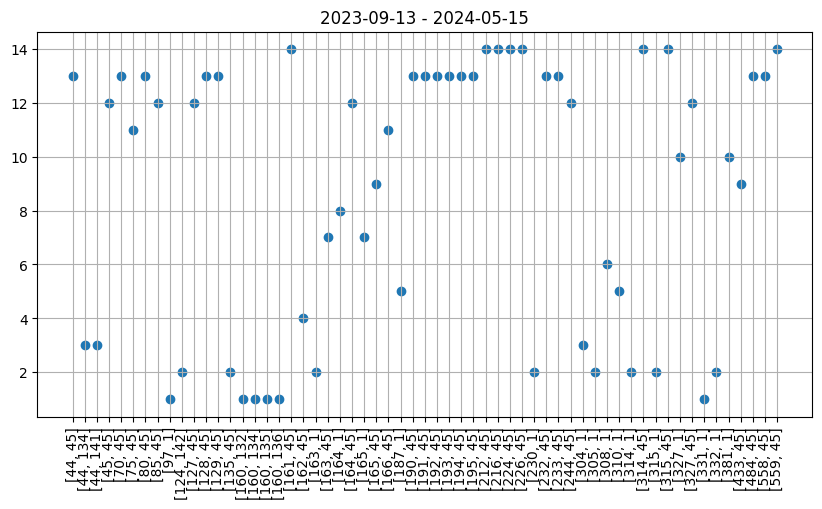

In [11]:
labels = [str(list(item)[1:]) for item in changes.keys()]
plt.figure(figsize=(10, 5))
plt.scatter(y = changes.values(), x = labels)
plt.xticks(rotation=90)
plt.title(f"{min(dates)} - {max(dates)}")
plt.grid()
plt.show()


In [12]:
# for label, y in scattering.items():
#     label = list(label)[1:]
#     plt.scatter(y=y, x=dates[1:-1])
#     plt.xticks(rotation=90)
#     plt.title(f"Item: {label[0]} Part: {label[1]}")
#     plt.show()


In [13]:
df_be52 = [row for row in df_db.itertuples() if row.file_name in be52]
df_be52 = pd.DataFrame(df_be52)

In [14]:
scattering = {}
changes = {}
plotting = {}


dates = list(set(df_be52["date"]))

for file_name in be52:
    df = df_be52[df_be52["file_name"] == file_name]
    for row in df[df["date"] == dates[0]][["item", "part"]].itertuples():
        allvalues = [row_part.value for row_part in be5201.itertuples() if [row.item, row.part] == [row_part.item, row_part.part]]

        newvalues = [allvalues[index] - allvalues[index + 1] for index in range(len(allvalues)-1)]
        scattering[row] = newvalues

        amount = [1 for value in newvalues if value != 0]
        changes[row] = sum(amount)
    plotting[file_name] = changes
        

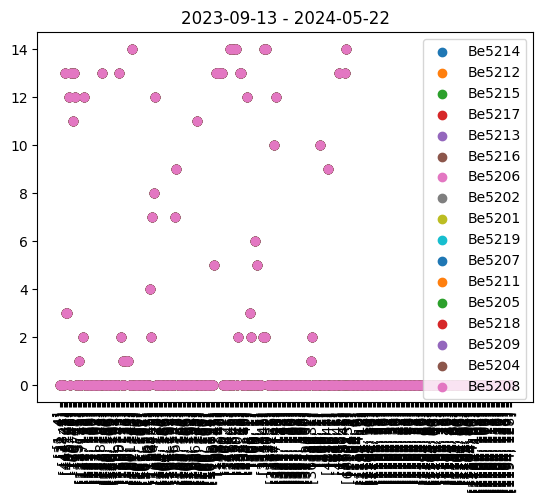

In [15]:
labels = [str(list(item)[1:]) for item in plotting["Be5201"].keys()]

for file in plotting:
    plt.scatter(y = plotting[file].values(), x = labels, label = file)
    plt.xticks(rotation=90)
    plt.title(f"{min(dates)} - {max(dates)}")
    plt.legend()

In [96]:
# Pivot maken: datum als kolommen, values als inhoud
df_pivot = df_db.pivot(index=["linac", "file_name", "item", "part"], columns="date", values="value")
df_pivot.reset_index(inplace=True)

dfchanges = df_pivot.iloc[:,4:-1] - df_pivot.iloc[:,5:]
df_pivot[["item", "part"]][dfchanges.sum(axis=1, skipna=True) != 0]

date,item,part
